<a href="https://colab.research.google.com/github/jojoclt/C/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Loading Data and importing Library

Please add the [FOLDER](https://drive.google.com/drive/folders/1nrhaTZC-0wGPOKA1ZwVdmmB2U1NqrMsJ?usp=sharing) to your root directory of Google Drive.
[paper link](https://www.researchgate.net/publication/330154837_Ripeness_Classification_of_Bananas_Using_an_Artificial_Neural_Network
)

also please join [trello](https://trello.com/b/uPv9MgUv/ml-proj-banana)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import os
import math
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#image filter
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
import cv2
from cv2 import imread, IMREAD_COLOR, IMREAD_GRAYSCALE

from itertools import repeat

from PIL import Image as im

In [ ]:
import sys
# sys.path.append('/content/drive/MyDrive/Project/')
if (os.getcwd() == '/content'): 
    os.chdir('./drive/MyDrive/Project')


# 1. Inputting Data

In [ ]:
PATH='Fayoum_University_Banana _Classes'
#print("os.listdir(PATH) :", os.listdir(PATH))
#print("sorted(os.listdir(PATH)) :", sorted(os.listdir(PATH)))
folder_name = os.listdir(PATH)
dataset = []

# Green Midripen Overripen Yellowish_green
data_keys = ('g','m','v','y')
dataset_label = []

for name in folder_name:
    subfolder = os.path.join(PATH, name)
    for fh in sorted(os.listdir(subfolder)):
        file_name = os.path.join(subfolder,fh)
        img = imread(file_name, IMREAD_COLOR)
        dataset.append(img)
        dataset_label.append(data_keys.index(fh[0]))


# 2. Image Preprocessing

In [ ]:
data_processed = []

r = 10
eps = 0.05
def process_image(img):
    # Step 1: Applying Guided Filter to preserve edges and smoothing on img
    # https://docs.opencv.org/4.6.0/da/d17/group__ximgproc__filters.html#ga86813d59f8452a9600e979c6287805f5
    imgproc_bgr = cv2.ximgproc.guidedFilter(img, img, r, eps)
    # Step 2: convert RGB to HSV
    hsv_img = cv2.cvtColor(imgproc_bgr, cv2.COLOR_BGR2HSV)
    # Step 3: Morphological Filtering 
    # https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
    # https://towardsdatascience.com/image-processing-class-egbe443-6-morphological-filter-e952c1ec886e
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(hsv_img, cv2.MORPH_CLOSE, kernel)
    return closing

data_processed = list(map(process_image, dataset))

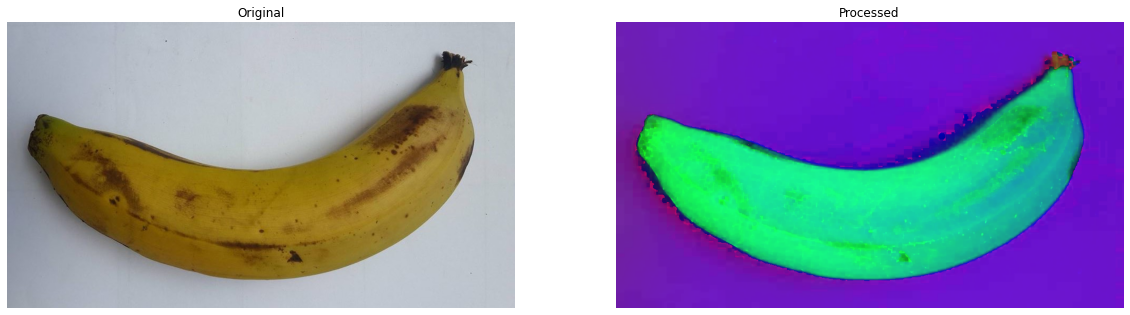

In [ ]:
# img = cv2.imread(os.path.join(PATH,'Green','g001.jpg'))
# imgProc = cv2.ximgproc.guidedFilter(img, img, 10, 0.05, -1)
# print(imgProc)
plt.figure(figsize=(20,20))
plt.subplot(121),plt.axis('off'),plt.title('Original')
plt.imshow(cv2.cvtColor(dataset[0],cv2.COLOR_BGR2RGB))
plt.subplot(122),plt.axis('off'),plt.title('Processed')
plt.imshow(data_processed[0])
# plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
c = Counter([ele.shape for ele in data_processed])
c

Counter({(540, 960, 3): 118,
         (536, 960, 3): 153,
         (1072, 1920, 3): 1,
         (636, 960, 3): 1})

In [ ]:
# cv2 width height reversed https://stackoverflow.com/a/22094421
IMG_SIZE = (960,540)
def resize_img(img, dst_size):
    return cv2.resize(img.astype(np.uint8), dst_size)
img_resize = list(map(resize_img, data_processed, repeat(IMG_SIZE)))

In [51]:
img_resize = np.array(img_resize)
type(img_resize)

numpy.ndarray

(540, 960, 3)


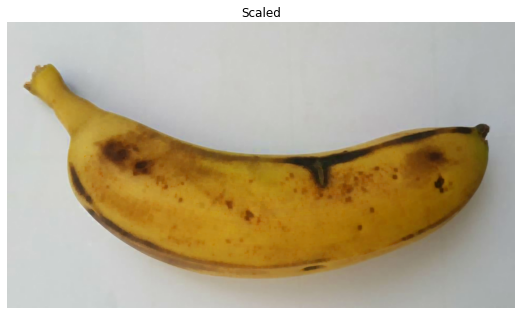

In [52]:
print(img_resize[22].shape)
plt.figure(figsize=(20,20))
plt.subplot(121),plt.axis('off'),plt.title('Scaled')
plt.imshow(cv2.cvtColor(img_resize[22],cv2.COLOR_HSV2RGB))

## 1.3 Image Augmentation

#3. Fruit Segmentation


https://en.wikipedia.org/wiki/Otsu%27s_method
Method for thresholding
https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
https://pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/


<class 'numpy.ndarray'>


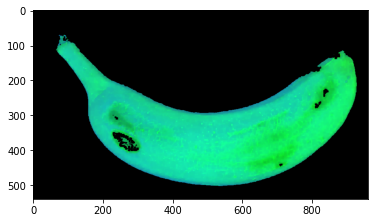

In [72]:
print(type(img_resize[0]))
image = img_resize[29]
# image = process_image(cv2.imread('/content/179394.jpg'))

gray = cv2.cvtColor((image), cv2.COLOR_BGR2GRAY)

# # Apply Otsu's method
threshold, thresholded_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # The foreground pixels will be white and the background pixels will be black
# # in the thresholded image
foreground = cv2.bitwise_and(image, image, mask=thresholded_image)
background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(thresholded_image))
plt.imshow(foreground)

## im test my segmentation

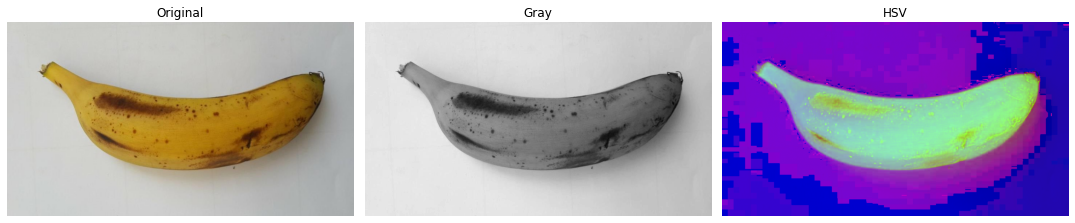

In [ ]:
#test if we should use hsv or grayscale
bnn_samp = cv2.imread(os.path.join(PATH,'Midripen','m013.jpg'))
gray_bnn = rgb2gray(bnn_samp)
hsv_bnn = rgb2hsv(bnn_samp)
#try re-color
#re_bnn = gray2rgb(gray_bnn)
plt.figure(figsize=(20,20))
plt.subplot(141),plt.axis('off'),plt.title('Original')
plt.imshow(cv2.cvtColor(bnn_samp,cv2.COLOR_BGR2RGB))
plt.subplot(142),plt.axis('off'),plt.title('Gray')
plt.imshow(gray_bnn, cmap="gray")
plt.subplot(143),plt.axis('off'),plt.title('HSV')
plt.imshow(hsv_bnn)
#plt.subplot(144),plt.axis('off'),plt.title('Re')
#plt.imshow(re_bnn)
plt.tight_layout()
plt.show()

#try use rgb2gray na jojo
#gray maybe best for segment (Green)
#for midrip hsv look better

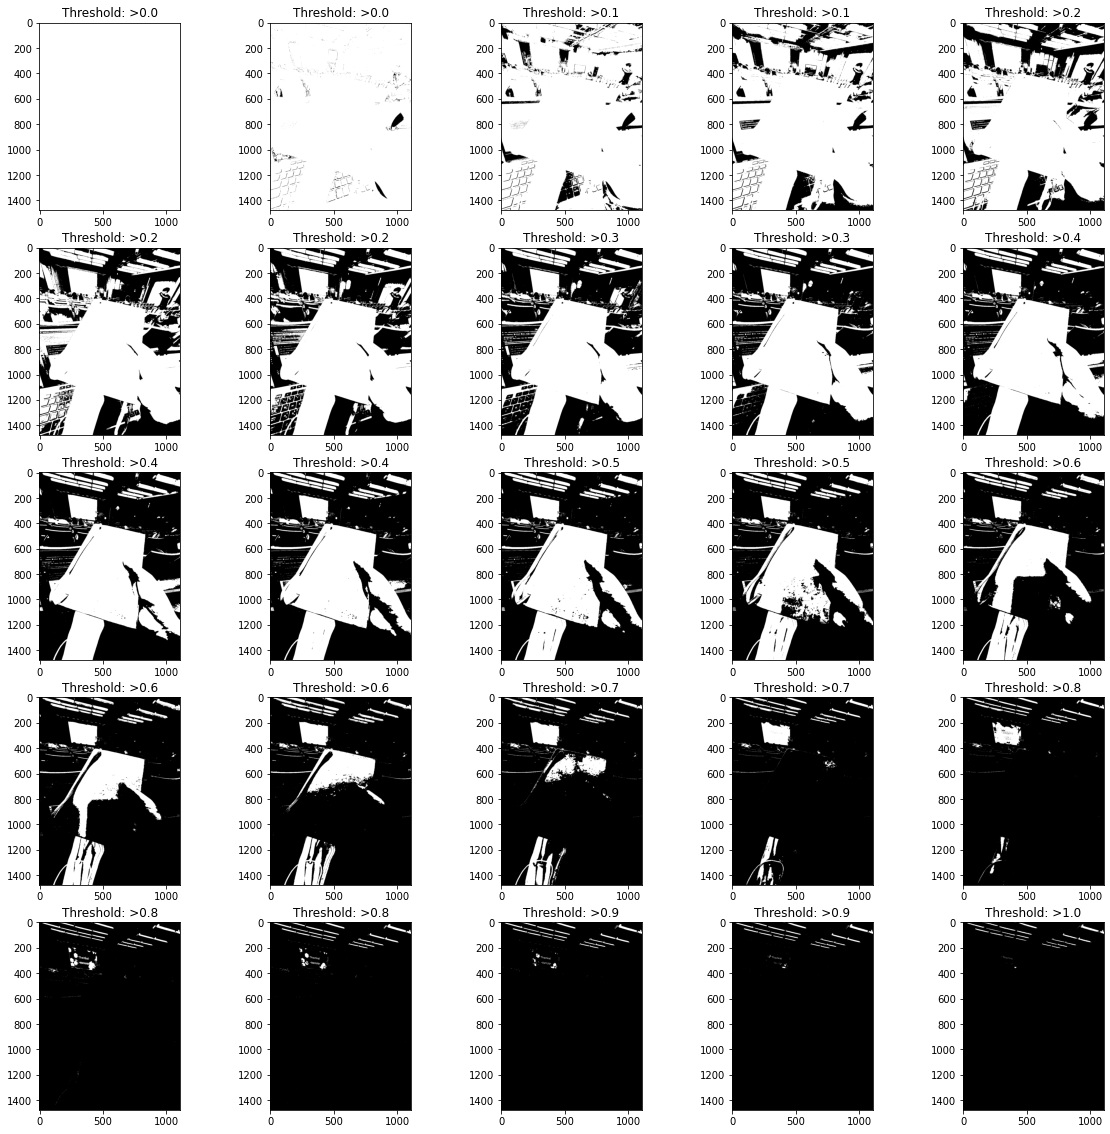

In [39]:
#idea: find threshold then mark outer area and turn it value to 0
#find threshold by
bnn_samp = cv2.imread(os.path.join(PATH,'Midripen','m013.jpg'))
gray_bnn = rgb2gray(bnn_samp)

plt.figure(figsize=(20,20))
for i in range(25):
  toogray_bnn = (gray_bnn > i*0.04)*1
  plt.subplot(5,5,i+1)

  plt.title("Threshold: >"+str(round(i*0.04,1)))
  plt.imshow(toogray_bnn, cmap = 'gray')
# plt.tight_layout()

#ref: https://www.geeksforgeeks.org/image-segmentation-using-pythons-scikit-image-module/

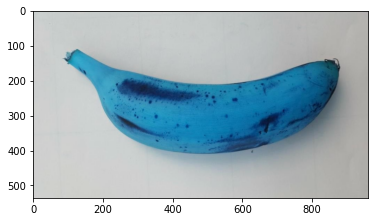

In [ ]:
#try
bnn_samp = cv2.imread(os.path.join(PATH,'Midripen','m013.jpg'))

plt.imshow(bnn_samp)


#4. Extracting Fruit Features


#5. Data Augmentation

In [ ]:
# https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    #tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

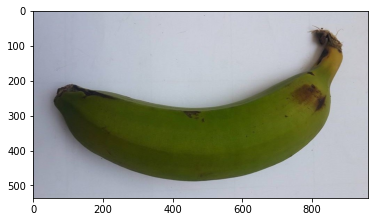

In [ ]:
idx = np.random.randint(0, 273)
image = cv2.cvtColor(dataset[idx], cv2.COLOR_BGR2RGB)
plt.imshow(image)

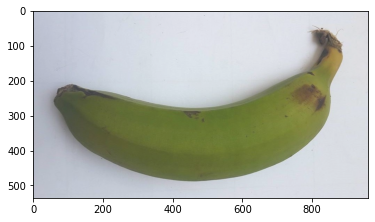

In [ ]:
augmented_image = data_augmentation(image).numpy().astype(int)
plt.imshow(augmented_image)

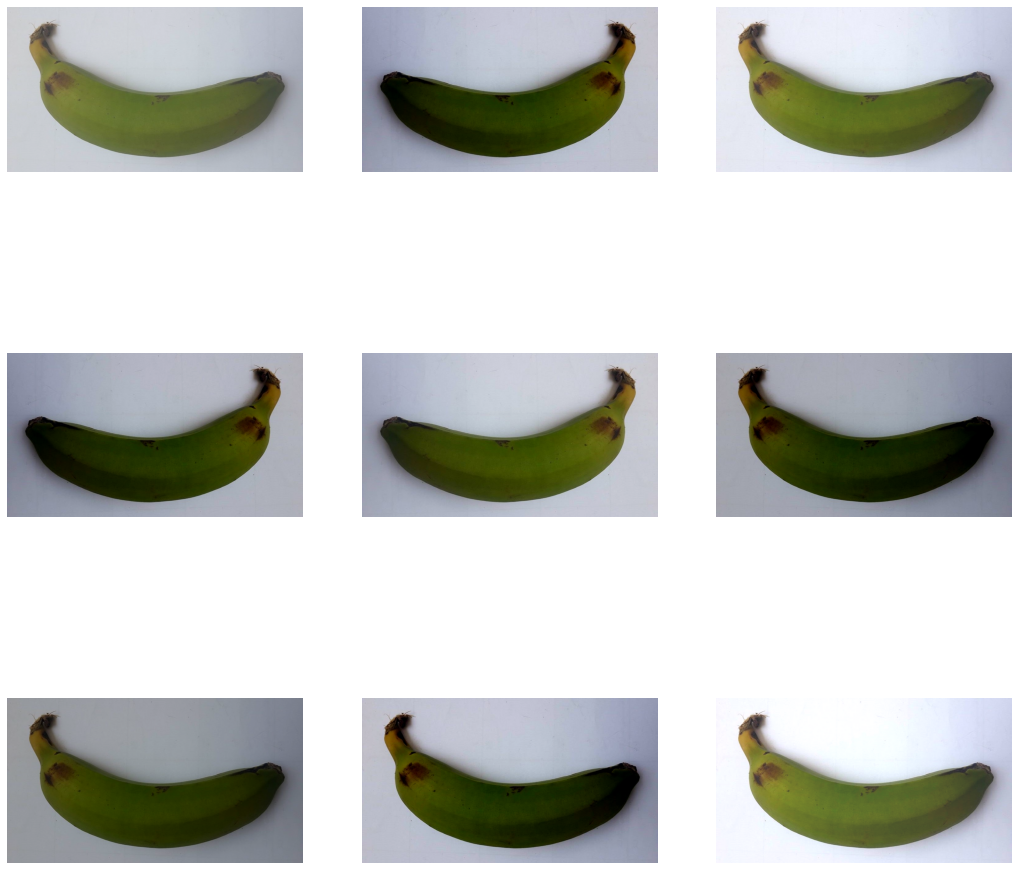

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(9):
    augmented_image = data_augmentation(image).numpy().astype(int)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

#6. Model